# Config

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import sys
import os

In [2]:
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path
import root

In [3]:
# Read datasets
client = pd.read_csv(root.DIR_DATA_RAW + 'client.csv')
electricity_prices = pd.read_csv(root.DIR_DATA_RAW + 'electricity_prices.csv')
gas_prices = pd.read_csv(root.DIR_DATA_RAW + 'gas_prices.csv')
historical_weather = pd.read_csv(root.DIR_DATA_RAW + 'historical_weather.csv')
forecast_weather = pd.read_csv(root.DIR_DATA_RAW + 'forecast_weather.csv')
train = pd.read_csv(root.DIR_DATA_RAW + 'train.csv')

In [4]:
print(electricity_prices.shape)
electricity_prices.head()

(15286, 4)


,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [5]:
print(gas_prices.shape)
gas_prices.head()

(637, 5)


,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [6]:
print(historical_weather.shape)
historical_weather.head()

(1710802, 18)


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [7]:
print(client.shape)
client.head()

(41919, 7)


,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [8]:
print(train.shape)
train.head()

(2018352, 9)


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [9]:
# Function to group data
def group_df(base_df, group_cols, group_data={'target': 'sum'}):
    df = base_df.groupby(group_cols).agg(group_data)
    df.reset_index(inplace=True)
    return df

# Add county to historical_weather dataset

In [10]:
# Get unique coordinates
coordinates = historical_weather[['longitude', 'latitude']].drop_duplicates()
coordinates

,longitude,latitude
0,21.7,57.6
1,22.2,57.6
2,22.7,57.6
3,23.2,57.6
4,23.7,57.6
...,...,...
107,26.2,59.7
108,26.7,59.7
109,27.2,59.7
110,27.7,59.7


In [11]:
# Get location of coordinates
unknown = 0
coordinates['county'] = ''
geolocator = Nominatim(user_agent="county_locator")

for i in range(len(coordinates)):

    latitude, longitude = coordinates.loc[i, 'latitude'], coordinates.loc[i, 'longitude']
    location = geolocator.reverse((latitude, longitude), language="en")

    if location:
        address = location.raw.get("address", {})
        county = address.get("county", "Unknown")
        coordinates.loc[i, 'county'] = str(county)
    else:
        unknown += 1
        coordinates.loc[i, 'county'] = 'Unknown'
coordinates

,longitude,latitude,county
0,21.7,57.6,Unknown
1,22.2,57.6,Unknown
2,22.7,57.6,Unknown
3,23.2,57.6,Saare County
4,23.7,57.6,Unknown
...,...,...,...
107,26.2,59.7,Lääne-Viru County
108,26.7,59.7,Lääne-Viru County
109,27.2,59.7,Jaama District
110,27.7,59.7,Jaama District


In [12]:
# Locations found
coordinates.county.unique()

array(['Unknown', 'Saare County', 'Võru County', 'Pechorsky District',
       'Palkinsky District', 'Pärnu County', 'Valga County',
       'Pskovsky District', 'Viljandi County', 'Tartu County',
       'Põlva County', 'Gdovsky District', 'Jõgeva County', 'Hiiu County',
       'Lääne County', 'Rapla County', 'Järva County', 'Harju County',
       'Lääne-Viru County', 'Ida-Viru County', 'Slantsevsky District',
       'Jaama District', 'Uusimaa'], dtype=object)

**Conclusiones**

- Se pueden eliminar los registros del clima de las siguientes locaciones, ya que NO pertenecen a ningun lugar de Estonia: Unknown, Uusimaa, Slantsevsky District, Jaama District, Gdovsky District, Pskovsky District, Pechorsky District, Palkinsky District.
- Se pueden identificar los 15 counties que existen en Estonia.

In [13]:
# Merge historical_weather with location
historical_weather = historical_weather.merge(
    coordinates[['latitude', 'longitude', 'county']],
    on=['latitude', 'longitude']
)
historical_weather = historical_weather.drop(['longitude', 'latitude'], axis=1)
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id,county
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,1.0,Unknown
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,1.0,Unknown
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,1.0,Unknown
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,1.0,Saare County
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,1.0,Unknown


In [14]:
# Drop historical_weather rows that are not from a county of Estonia
county_locations = [
        'Saare County',
        'Võru County',
        'Pärnu County',
        'Valga County',
        'Viljandi County',
        'Tartu County',
        'Põlva County',
        'Jõgeva County',
        'Hiiu County',
        'Lääne County',
        'Rapla County',
        'Järva County',
        'Harju County',
        'Lääne-Viru County',
        'Ida-Viru County'
        ]
historical_weather = historical_weather[historical_weather['county'].isin(county_locations)]
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id,county
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,1.0,Saare County
10,2021-09-01 00:00:00,13.0,11.5,0.0,0.0,998.5,100,85,17,98,4.027778,354,0.0,0.0,0.0,1.0,Võru County
11,2021-09-01 00:00:00,13.0,12.1,0.1,0.0,988.9,100,100,39,99,3.805556,360,0.0,0.0,0.0,1.0,Võru County
14,2021-09-01 00:00:00,13.3,10.7,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,Saare County
15,2021-09-01 00:00:00,14.4,11.3,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,Saare County


In [15]:
# Check that all the rows in historical_weather are from a county in Estonia
print('Counties:', historical_weather.county.unique())
print('Number of counties:', len(historical_weather.county.unique()))

Counties: ['Saare County' 'Võru County' 'Pärnu County' 'Valga County'
 'Viljandi County' 'Tartu County' 'Põlva County' 'Jõgeva County'
 'Hiiu County' 'Lääne County' 'Rapla County' 'Järva County' 'Harju County'
 'Lääne-Viru County' 'Ida-Viru County']
Number of counties: 15


In [16]:
# Change county name to an integer (the same as the test dataset)
county_to_int = {'Saare County' : 10,
                 'Võru County' : 15,
                 'Pärnu County' : 7,
                 'Valga County' : 13,
                 'Viljandi County' : 14,
                 'Tartu County' : 11,
                 'Põlva County' : 8,
                 'Jõgeva County' : 4,
                 'Hiiu County' : 1,
                 'Lääne County' : 6,
                 'Rapla County' : 9,
                 'Järva County' : 3,
                 'Harju County' : 0,
                 'Lääne-Viru County' : 5,
                 'Ida-Viru County' : 2}

historical_weather['county'] = historical_weather['county'].map(county_to_int)
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id,county
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,1.0,10
10,2021-09-01 00:00:00,13.0,11.5,0.0,0.0,998.5,100,85,17,98,4.027778,354,0.0,0.0,0.0,1.0,15
11,2021-09-01 00:00:00,13.0,12.1,0.1,0.0,988.9,100,100,39,99,3.805556,360,0.0,0.0,0.0,1.0,15
14,2021-09-01 00:00:00,13.3,10.7,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,10
15,2021-09-01 00:00:00,14.4,11.3,0.0,0.0,1016.2,51,35,0,64,7.611111,5,0.0,0.0,0.0,1.0,10


In [17]:
# Change datetime column to datetime type
historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

In [18]:
# Group data by county and datetype, get avg from all cols
historical_weather = group_df(historical_weather, ['county', 'datetime'], 'mean')
historical_weather.head(3)

,county,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id
0,0,2021-09-01 00:00:00,13.79,10.73,0.0,0.0,1010.56,54.4,56.9,3.5,3.9,5.325000,342.0,0.0,0.0,0.0,1.0
1,0,2021-09-01 01:00:00,13.62,10.35,0.0,0.0,1010.47,28.9,26.0,1.1,15.8,5.327778,345.8,0.0,0.0,0.0,1.0
2,0,2021-09-01 02:00:00,13.13,10.07,0.0,0.0,1010.14,13.7,14.5,0.1,1.8,5.091667,340.8,0.0,0.0,0.0,1.0


# Filter train dataset by product_type, is_business and county
Primero vamos a hacer un EDA para saber cómo hacer el filtrado del dataset ya que este contiene muchos registros y no tenemos la capacidad computacional para correr modelos con tantos datos.

## Consumption data

In [19]:
# Filter consumption data
train_consumption = train[train['is_consumption'] == 0]
train_consumption.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
6,0,1,0,0.000,0,2021-09-01 00:00:00,0,6,3
8,0,1,1,0.000,0,2021-09-01 00:00:00,0,8,4


<Axes: xlabel='product_type', ylabel='target'>

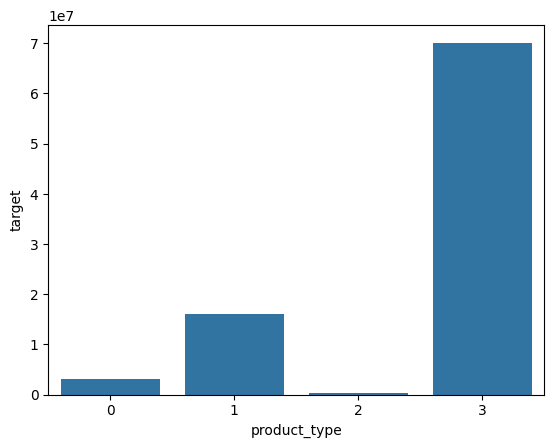

In [20]:
# Group by product_type
df = group_df(train_consumption, ['product_type'])
df.head()
sns.barplot(x='product_type', y='target', data=df)

<Axes: xlabel='is_business', ylabel='target'>

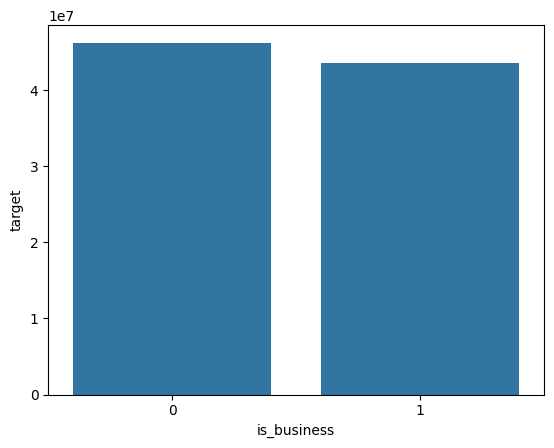

In [21]:
# Group by is_business
df = group_df(train_consumption, ['is_business'])
df.head()
sns.barplot(x='is_business', y='target', data=df)

<Axes: xlabel='is_business', ylabel='target'>

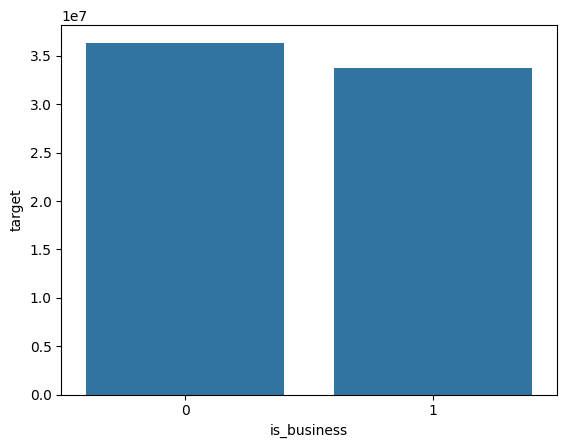

In [22]:
# Group records where product_type=3 by is_business
df = group_df(train_consumption[train_consumption['product_type'] == 3], ['is_business'])
df.head()
sns.barplot(x='is_business', y='target', data=df)

## Production data

In [23]:
# Filter production data
train_production = train[train['is_consumption'] == 1]
train_production.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
5,0,0,3,656.859,1,2021-09-01 00:00:00,0,5,2
7,0,1,0,59.000,1,2021-09-01 00:00:00,0,7,3
9,0,1,1,501.760,1,2021-09-01 00:00:00,0,9,4


<Axes: xlabel='product_type', ylabel='target'>

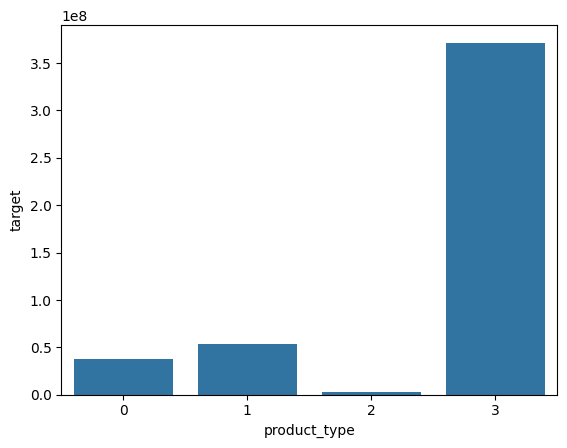

In [24]:
# Group by product_type
df = group_df(train_production, ['product_type'])
df.head()
sns.barplot(x='product_type', y='target', data=df)

<Axes: xlabel='is_business', ylabel='target'>

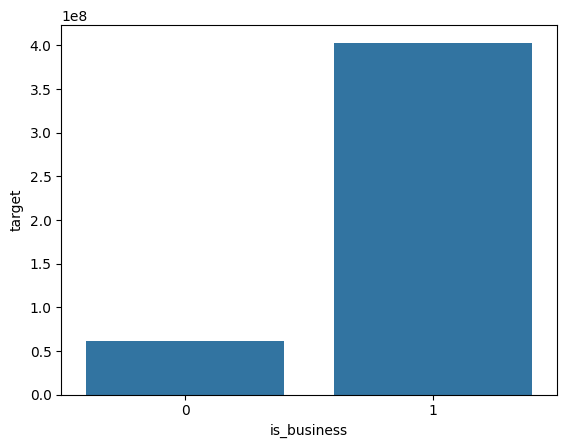

In [25]:
# Group by is_business
df = group_df(train_production, ['is_business'])
df.head()
sns.barplot(x='is_business', y='target', data=df)

<Axes: xlabel='is_business', ylabel='target'>

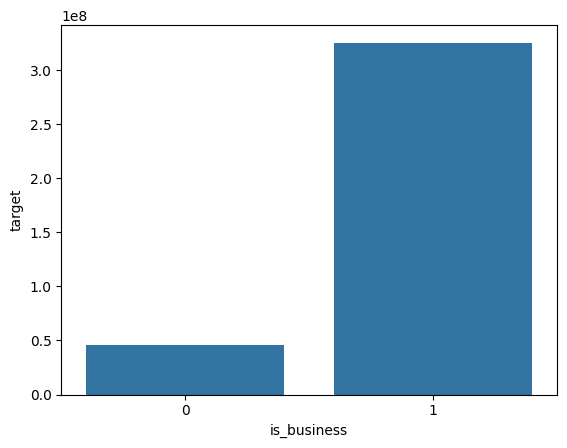

In [26]:
# Group records where product_type=3 by is_business
df = group_df(train_production[train_production['product_type'] == 3], ['is_business'])
df.head()
sns.barplot(x='is_business', y='target', data=df)

**Conclusiones**

- **Dataset de consumo:** el tipo de contrato que más energía consume es el 3 y las empresas son las que más energía consumen. Para el tipo de contrato 3, las empresas son las que más energía consumen.

- **Dataset de consumo:** el tipo de contrato que más energía produce es el 3 y las empresas son las que más energía producen. Para el tipo de contrato 3, las empresas son las que más energía producen.

Debido a que las empresas con tipo de contrato 3 son las que más enegría consumen y producen, nos vamos a enfocar en este segmento, pues esta predicción nos puede ayudar a ahorrar la mayor cantidad de dinero.

## Filter by product_type = 3 and is_business = 1

Se va a contruir un dataset de consumo y otro de producción de energía. Se va a tomar en cuenta unicamente el semneto de empresas donde el tipo de producto es el 3 (is_business = 1 and product_type = 3).

In [27]:
# Consumption dataset
train_c = train[(train['is_consumption'] == 1) & (train['is_business'] == 1) & (train['product_type'] == 3)]
train_c = train_c.drop(['is_consumption', 'is_business', 'product_type', 'data_block_id', 'row_id', 'prediction_unit_id'], axis=1)
print('Consumption shape:', train_c.shape)
train_c.head()

Consumption shape: (244992, 3)


,county,target,datetime
11,0,5155.056,2021-09-01 00:00:00
17,1,30.778,2021-09-01 00:00:00
21,2,266.637,2021-09-01 00:00:00
29,3,729.075,2021-09-01 00:00:00
37,4,356.901,2021-09-01 00:00:00


In [28]:
# Production dataset
train_p = train[(train['is_consumption'] == 0) & (train['is_business'] == 1) & (train['product_type'] == 3)]
train_p = train_p.drop(['is_consumption', 'is_business', 'product_type', 'data_block_id', 'row_id', 'prediction_unit_id'], axis=1)
print('Production shape:', train_p.shape)
train_p.head()

Production shape: (244992, 3)


,county,target,datetime
10,0,0.315,2021-09-01 00:00:00
16,1,0.000,2021-09-01 00:00:00
20,2,0.000,2021-09-01 00:00:00
28,3,0.000,2021-09-01 00:00:00
36,4,0.000,2021-09-01 00:00:00


In [29]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [30]:
# Client dataset
client = client[(client['is_business'] == 1) & (client['product_type'] == 3)]
client = client.drop(['is_business', 'product_type', 'data_block_id'], axis=1)
print('Client shape:', client.shape)
client.head()

Client shape: (10176, 4)


,county,eic_count,installed_capacity,date
5,0,265,13417.79,2021-09-01
8,1,12,295.50,2021-09-01
10,2,22,581.50,2021-09-01
14,3,38,2268.70,2021-09-01
18,4,28,1084.00,2021-09-01


## Filter by a county

<Axes: xlabel='county', ylabel='target'>

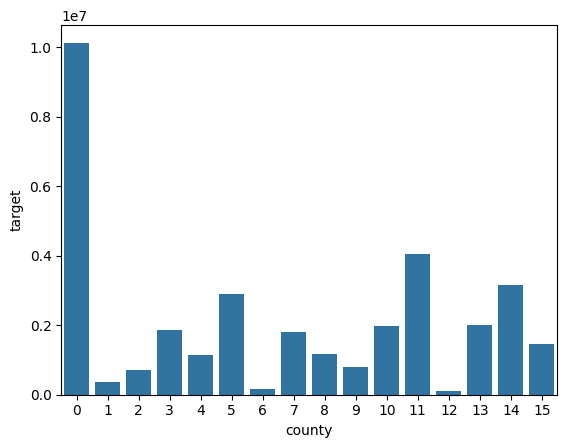

In [31]:
# Group production by county
df = group_df(train_p, ['county'])
sns.barplot(x='county', y='target', data=df)

<Axes: xlabel='county', ylabel='target'>

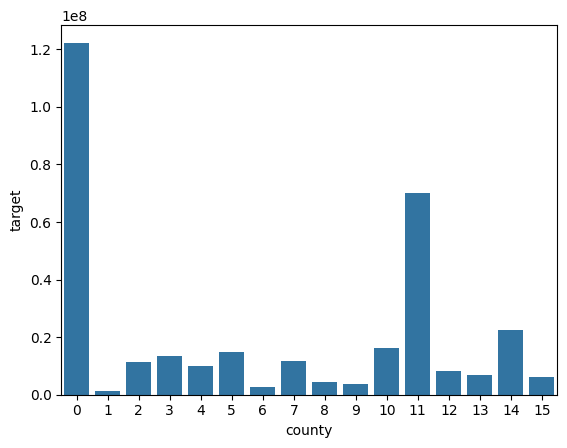

In [32]:
# Group consumption by county
df = group_df(train_c, ['county'])
sns.barplot(x='county', y='target', data=df)

El county que más produce y consume energía es el 0, es decir, Harju. Esto tiene sentido ya que allí se encuntra la capital de Estonia. Solo se van a usar los datos de Harju para el modelo, puesto que allí es donde más beneficio económico se puede obtener al hacer las predicciones.

In [33]:
# Filter datasets where county is Harju (0)
train_c = train_c[train_c['county'] == 0]
train_p = train_p[train_p['county'] == 0]
client = client[client['county'] == 0]
historical_weather = historical_weather[historical_weather['county'] == 0]

# Drop column county
train_c = train_c.drop(['county'], axis=1)
train_p = train_p.drop(['county'], axis=1)
client = client.drop(['county'], axis=1)
historical_weather = historical_weather.drop(['county'], axis=1)

# EDA

## Show datasets

In [34]:
train_c.head()

,target,datetime
11,5155.056,2021-09-01 00:00:00
133,4953.258,2021-09-01 01:00:00
255,4910.692,2021-09-01 02:00:00
377,4700.725,2021-09-01 03:00:00
499,4857.681,2021-09-01 04:00:00


In [35]:
train_p.head()

,target,datetime
10,0.315,2021-09-01 00:00:00
132,0.353,2021-09-01 01:00:00
254,0.338,2021-09-01 02:00:00
376,0.303,2021-09-01 03:00:00
498,0.424,2021-09-01 04:00:00


In [36]:
client.head()

,eic_count,installed_capacity,date
5,265,13417.79,2021-09-01
66,265,13417.79,2021-09-02
127,265,13417.79,2021-09-03
188,265,13417.79,2021-09-04
249,265,13417.79,2021-09-05


In [37]:
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,data_block_id
0,2021-09-01 00:00:00,13.79,10.73,0.0,0.0,1010.56,54.4,56.9,3.5,3.9,5.325000,342.0,0.0,0.0,0.0,1.0
1,2021-09-01 01:00:00,13.62,10.35,0.0,0.0,1010.47,28.9,26.0,1.1,15.8,5.327778,345.8,0.0,0.0,0.0,1.0
2,2021-09-01 02:00:00,13.13,10.07,0.0,0.0,1010.14,13.7,14.5,0.1,1.8,5.091667,340.8,0.0,0.0,0.0,1.0
3,2021-09-01 03:00:00,12.74,9.94,0.0,0.0,1010.09,8.6,6.5,0.9,7.5,4.944444,335.5,0.0,0.0,0.0,1.0
4,2021-09-01 04:00:00,12.46,10.03,0.0,0.0,1009.83,4.1,2.8,0.6,4.2,4.669444,330.6,0.0,0.0,0.0,1.0


In [38]:
electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [39]:
gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [40]:
# Drop data_block_id columns
historical_weather = historical_weather.drop(['data_block_id'], axis=1)
electricity_prices = electricity_prices.drop(['data_block_id'], axis=1)
gas_prices = gas_prices.drop(['data_block_id'], axis=1)

## Data types

In [41]:
# Numer of nulls
print('Train consumption')
print(train_c.dtypes)
print('\nTrain production')
print(train_p.dtypes)
print('\nClient:')
print(client.dtypes)
print('\nHistorical weather')
print(historical_weather.dtypes)
print('\nElectricity prices')
print(electricity_prices.dtypes)
print('\nGas prices')
print(gas_prices.dtypes)

Train consumption
target      float64
datetime     object
dtype: object

Train production
target      float64
datetime     object
dtype: object

Client:
eic_count               int64
installed_capacity    float64
date                   object
dtype: object

Historical weather
datetime                  datetime64[ns]
temperature                      float64
dewpoint                         float64
rain                             float64
snowfall                         float64
surface_pressure                 float64
cloudcover_total                 float64
cloudcover_low                   float64
cloudcover_mid                   float64
cloudcover_high                  float64
windspeed_10m                    float64
winddirection_10m                float64
shortwave_radiation              float64
direct_solar_radiation           float64
diffuse_radiation                float64
dtype: object

Electricity prices
forecast_date     object
euros_per_mwh    float64
origin_date       object

In [42]:
# Change date columns to datetime type
train_c['datetime'] = pd.to_datetime(train_c['datetime'])
train_p['datetime'] = pd.to_datetime(train_p['datetime'])
client['date'] = pd.to_datetime(client['date'])
historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices['origin_date'] = pd.to_datetime(electricity_prices['origin_date'])
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])
gas_prices['origin_date'] = pd.to_datetime(gas_prices['origin_date'])

## Missing values

In [43]:
# Numer of nulls
print('Train consumption')
print(train_c.isnull().sum())
print('\nTrain production')
print(train_p.isnull().sum())
print('\nClient production')
print(client.isnull().sum())
print('\nHistorical weather')
print(historical_weather.isnull().sum())
print('\nElectricity prices')
print(electricity_prices.isnull().sum())
print('\nGas prices')
print(gas_prices.isnull().sum())

Train consumption
target      4
datetime    0
dtype: int64

Train production
target      4
datetime    0
dtype: int64

Client production
eic_count             0
installed_capacity    0
date                  0
dtype: int64

Historical weather
datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
dtype: int64

Electricity prices
forecast_date    0
euros_per_mwh    0
origin_date      0
dtype: int64

Gas prices
forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
dtype: int64


In [44]:
# Show rows where target is null
print(train_c[train_c['target'].isnull()])
print(train_p[train_p['target'].isnull()])

         target            datetime
178951      NaN 2021-10-31 03:00:00
634879      NaN 2022-03-27 03:00:00
1332469     NaN 2022-10-30 03:00:00
1806265     NaN 2023-03-26 03:00:00
         target            datetime
178950      NaN 2021-10-31 03:00:00
634878      NaN 2022-03-27 03:00:00
1332468     NaN 2022-10-30 03:00:00
1806264     NaN 2023-03-26 03:00:00


In [45]:
# Sort by datetime to correctly interpolate
train_c = train_c.sort_values(by='datetime')
train_p = train_p.sort_values(by='datetime')

# Fill missing values by interpolating linearly
train_c['target'] = train_c['target'].interpolate(method='linear', limit_direction='both')
train_p['target'] = train_p['target'].interpolate(method='linear', limit_direction='both')

# Check remaining missing values
print('Missing value of train_c:', train_c['target'].isnull().sum())
print('Missing value of train_p:', train_p['target'].isnull().sum())


Missing value of train_c: 0
Missing value of train_p: 0


## Duplicates

In [46]:
# Check for duplicates in dataframes
print('Sum of duplicates in train_c:', train_c.duplicated().sum())
print('Sum of duplicates in train_p:', train_p.duplicated().sum())
print('Sum of duplicates in client:', client.duplicated().sum())
print('Sum of duplicates in historical_weather:', historical_weather.duplicated().sum())
print('Sum of duplicates in electricity_prices:', electricity_prices.duplicated().sum())
print('Sum of duplicates in gas_prices:', gas_prices.duplicated().sum())

Sum of duplicates in train_c: 0
Sum of duplicates in train_p: 0
Sum of duplicates in client: 0
Sum of duplicates in historical_weather: 0
Sum of duplicates in electricity_prices: 0
Sum of duplicates in gas_prices: 0


In [47]:
# Check for date duplicates
print('Number of date duplicates in train_c:', train_c['datetime'].duplicated().sum())
print('Number of date duplicates in train_p:', train_p['datetime'].duplicated().sum())
print('Number of date duplicates in client:', client['datetime'].duplicated().sum())
print('Number of date duplicates in historical_weather:', historical_weather['datetime'].duplicated().sum())
print('Number of date duplicates in electricity_prices:', electricity_prices['forecast_date'].duplicated().sum())
print('Number of date duplicates in gas_prices:', gas_prices['forecast_date'].duplicated().sum())

Number of date duplicates in train_c: 0
Number of date duplicates in train_p: 0


KeyError: 'datetime'

## Data distribution
describe y ditribuciones

## Outliers

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(train_c['target'], orient='h')
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(train_p['target'], orient='h')
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(electricity_prices['euros_per_mwh'], orient='h')
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(gas_prices['lowest_price_per_mwh'], orient='h')
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(gas_prices['highest_price_per_mwh'], orient='h')
plt.show()

## Correlations

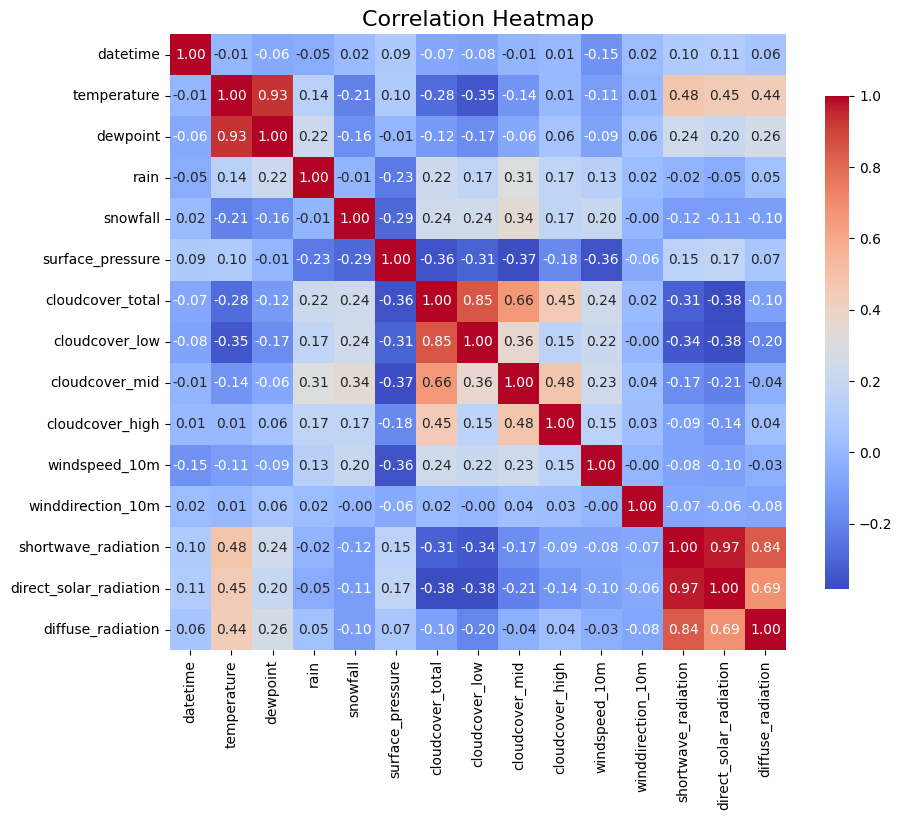

In [48]:
correlation_matrix = historical_weather.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Las variables con correlación mayor al 80% son:
- cloudcover_low - cloudcover_total: 85%
- direct_solar_radiation - shortwave_radiation: 97%
- diffuse_radiation - shortwave_radiation: 84%

Se va a eliminar la variable con menor varianza

In [49]:
# Variance of correlated fields
print('Variance of cloudcover_low', historical_weather['cloudcover_low'].var())
print('Variance of cloudcover_total', historical_weather['cloudcover_total'].var())
print('Variance of direct_solar_radiation:', historical_weather['direct_solar_radiation'].var())
print('Variance of shortwave_radiation:', historical_weather['shortwave_radiation'].var())
print('Variance of diffuse_radiation:', historical_weather['diffuse_radiation'].var())

Variance of cloudcover_low 1502.877512474093
Variance of cloudcover_total 1308.5671696969293
Variance of direct_solar_radiation: 17211.560588675125
Variance of shortwave_radiation: 31555.495098004267
Variance of diffuse_radiation: 3582.9483844546976


Variables con mayor variana entre cada par correlacionado:
- cloudcover_low - cloudcover_total: cloudcover_low
- direct_solar_radiation - shortwave_radiation: shortwave_radiation
- diffuse_radiation - shortwave_radiation: shortwave_radiation

Se van a mantener las variables cloudcover_low y shortwave_radiation

In [50]:
historical_weather = historical_weather.drop(['cloudcover_total', 'direct_solar_radiation', 'diffuse_radiation'], axis=1)

## Otros
- catgorico no hay nada
- cosas de sries de tiempo
- mostrar cuantos datos se usaran en total
- estandarizar si es necesario

In [ ]:
# Get info from each column
historical_weather.describe()

In [ ]:
# # Graph variable for every county to look for unusual data
# counties = historical_weather['county'].unique()
# column = 'temperature'

# fig, axes = plt.subplots(len(counties), 1, figsize=(10, len(counties) * 3))
# for i, county in enumerate(counties):
#     df = historical_weather[historical_weather['county'] == county]
#     ax = axes[i]
#     ax.plot(df['datetime'], df[column])
#     ax.set_title(f'County {county}')
#     ax.set_ylabel(column)
#     ax.tick_params(axis='x', rotation=45)

# plt.tight_layout(rect=[0, 0, 1, 0.97])
# plt.show()

In [ ]:
# daily_avg_temp = group_df(historical_weather, [historical_weather['datetime'].dt.date, 'county'], group_data={'temperature': 'mean'})
# plt.figure(figsize=(14, 8))

# # Loop through each county and plot its daily average temperature
# for county in daily_avg_temp['county'].unique():
#     county_data = daily_avg_temp[daily_avg_temp['county'] == county]
#     plt.plot(county_data['datetime'], county_data['temperature'], label=f'County {county}')

# # Add labels and title
# plt.xlabel('Date')
# plt.ylabel('Average Temperature')
# plt.title('Daily Average Temperature by County')
# plt.legend(title="County")
# plt.xticks(rotation=45)
# plt.tight_layout()

# plt.show()

In [ ]:
# # Plot production and consumption
# train_c_daily = group_df(train_c, ['datetime'.dt.date], group_data={'target': 'sum'})
# train_p_daily = group_df(train_p, ['datetime'.dt.date], group_data={'target': 'sum'})

# plt.figure(figsize=(15, 5))
# plt.plot(train_c_daily['datetime'], train_c_daily['target'], label='Consumption')
# plt.plot(train_p_daily['datetime'], train_p_daily['target'], label='Production')
# plt.title('Consumption vs Production')
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

# Save datasets

In [61]:
# Consumption dataset
consumption_path = root.DIR_DATA_RAW + 'train_consumption.pkl'
train_c.to_pickle(consumption_path)

In [62]:
# Production dataset
production_path = root.DIR_DATA_RAW + 'train_production.pkl'
train_p.to_pickle(production_path)

In [63]:
# Client
client_path = root.DIR_DATA_RAW + 'client_processed.pkl'
client.to_pickle(client_path)

In [64]:
# Historical weather
weather_path = root.DIR_DATA_RAW + 'hist_weather_processed.pkl'
historical_weather.to_pickle(weather_path) 

In [65]:
# Electricity prices
electricity_path = root.DIR_DATA_RAW + 'electricity_processed.pkl'
electricity_prices.to_pickle(electricity_path)

In [66]:
# Gas prices
gas_path = root.DIR_DATA_RAW + 'gas_processed.pkl'
gas_prices.to_pickle(gas_path)